### CSE 5320 Neural Networks Project 2
#### Report (with Code)
Josias Moukpe\
11/18/2022

#### Introduction
Object detection is an advanced form of image classification where a neural network predicts objects in an image and points them out in bounding boxes. Object detection thus refers to the detection and localization of objects in an image that belongs to a predefined set of classes. Tasks like detection, recognition, or localization find widespread applicability in real-world scenarios such as autonomous driving, robotics, product quality assurance, etc., making object detection (also referred to as object recognition) a very important subdomain of Computer Vision. [2] We call Real-Time object detection when the objects in images can be recognized in mere milliseconds allowing for in-time reactions based on the detection. Our project will aim to build a real-time object detector to find and track objects of defined classes in images or video feeds.

#### Problem
This objective combines object classificationn and localization (bounding box regression task). To process images and capture the features, we will leverage convolutional neural networks and capture local pixel structures. We will comment on how our model performs in real-time object detection. To train our model, we will use the MS COCO dataset [1]. This dataset contains more than 200,000 labeled color images of 1.5 million object instances and 80 object categories. Each image is 640 x 480 pixels and includes various forms of annotations such as key points, captions, segmentations, and bounding boxes (which interest us). The model will take an image or batch of images and outputs the classes and bounding boxes of all objects detected in that image.

#### Methodology
To prepare the data, we .

#### Benchmarking
To measure training performance, we 

#### Conclusion



References\
[1] https://cocodataset.org/#home
[2] https://www.v7labs.com/blog/yolo-object-detection

Obtaining the COCO 2017 Dataset

In [9]:
# list the contents of the current 
# directory on my remote server
!ls
%cd "/notebooks/data"
!ls

annotations  test2017  train2017  val2017
/notebooks/data
annotations  test2017  train2017  val2017


In [1]:
# # downloading coco (2017) dataset
# !wget http://images.cocodataset.org/zips/train2017.zip
# !wget http://images.cocodataset.org/zips/val2017.zip
# !wget http://images.cocodataset.org/zips/test2017.zip
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# !wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
# !wget http://images.cocodataset.org/annotations/image_info_test2017.zip

# # unzip the files
# !unzip train2017.zip
# !unzip val2017.zip
# !unzip test2017.zip
# !unzip annotations_trainval2017.zip
# !unzip stuff_annotations_trainval2017.zip
# !unzip image_info_test2017.zip

# # remove the zip files
# !rm train2017.zip
# !rm val2017.zip
# !rm test2017.zip
# !rm annotations_trainval2017.zip
# !rm stuff_annotations_trainval2017.zip
# !rm image_info_test2017.zip


--2022-11-19 03:20:27--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.133.57, 3.5.19.134, 52.217.198.161, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.133.57|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  5.74MB/s    in 52m 10s 

2022-11-19 04:12:37 (5.89 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2022-11-19 04:12:38--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.132.25, 52.217.229.137, 52.216.233.75, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.132.25|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 7

In [52]:

!wget -O yolov3.weights https://pjreddie.com/media/files/yolov3.weights

--2022-11-19 08:39:30--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  6.12MB/s    in 42s     

2022-11-19 08:40:17 (5.69 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [18]:
# install gluoncv to help with the dataset
# %pip install gluoncv
# %pip install mxnet
# %pip install opencv-python

In [35]:
# imports 
from gluoncv import data, utils
from matplotlib import pyplot as plt
import numpy as np
import cv2
from random import randint
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.python.client import device_lib
import tensorboard

%matplotlib inline
print(tf.__version__)

2.9.1


In [20]:
# check if gpu is available
numGPUs = len(tf.config.experimental.list_physical_devices('GPU'))

print('Num GPUs Available: ', numGPUs)

if numGPUs > 0:
    print(tf.test.gpu_device_name())
    for device in device_lib.list_local_devices():
        print(device.physical_device_desc)

Num GPUs Available:  1
/device:GPU:0

device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:00:05.0, compute capability: 8.6


In [21]:
# loading the coco dataset
train_ds = data.COCODetection('.', splits=['instances_train2017'])
val_ds = data.COCODetection('.', splits=['instances_val2017'])
# test_ds = data.COCODetection(splits=['test2017']) # TODO: figure this out 

# print the length of the dataset
print('Length of training dataset:', len(train_ds))
print('Length of validation dataset:', len(val_ds))

/usr/local/lib/python3.9/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Collecting pycocotools

Downloading pycocotools-2.0.6.tar.gz (24 kB)

Installing build dependencies: started

Installing build dependencies: finished with status 'done'

Getting requirements to build wheel: started

Getting requirements to build wheel: finished with status 'done'

Preparing metadata (pyproject.toml): started

Preparing metadata (pyproject.toml): finished with status 'done'

Requirement already satisfied: numpy in /usr/local/lib/python3.9/dist-packages (from pycocotools) (1.23.1)

Requirement already satisfied: matplotlib>=2.1.0 in /usr/local/lib/python3.9/dist-packages (from pycocotools) (3.5.2)

Requirement already satisfied: pillow>=6.2.0 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (9.2.0)

Requirement already satisfied: fonttools>=4.22.0 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (4.34.4)

Requirement already satisfied: python-dateutil>=2.7 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (2.8.2)

Requirement already satisfied: packaging>=20.0 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (21.3)

Requirement already satisfied: cycler>=0.10 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (0.11.0)

Requirement already satisfied: kiwisolver>=1.0.1 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (1.4.3)

Requirement already satisfied: pyparsing>=2.2.1 in /usr/local/lib/python3.9/dist-packages (from matplotlib>=2.1.0->pycocotools) (3.0.9)

Requirement already satisfied: six>=1.5 in /usr/lib/python3/dist-packages (from python-dateutil>=2.7->matplotlib>=2.1.0->pycocotools) (1.14.0)

Building wheels for collected packages: pycocotools

Building wheel for pycocotools (pyproject.toml): started

Building wheel for pycocotools (pyproject.toml): finished with status 'done'

Created wheel for pycocotools: filename=pycocotools-2.0.6-cp39-cp39-linux_x86_64.whl size=400227 sha256=0b26a8a8ea0f02fd7ab5f60e77c8355c087c0dd75d1a1919d2852af721856eb6

Stored in directory: /root/.cache/pip/wheels/2f/58/25/e78f1f766e904a9071266661d20d0bc6644df86bcd160aba11

Successfully built pycocotools

Installing collected packages: pycocotools

Successfully installed pycocotools-2.0.6

WARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv


loading annotations into memory...
Done (t=13.29s)
creating index...
index created!
loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
Length of training dataset: 117266
Length of validation dataset: 4952


Image size (height, width, RGB): (425, 640, 3)
Label: [[407.89 270.11 520.03 418.39  61.  ]
 [567.26 263.64 639.   309.51  71.  ]]
shpae of label: (2, 5)
number of objects in the image: 2
bounding boxes (# boxes, min x, min y, max x, max y): 
 [[407.89 270.11 520.03 418.39]
 [567.26 263.64 639.   309.51]]
class ids (# boxes, class id): 
 [[61.]
 [71.]]


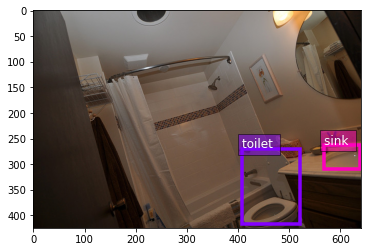

In [34]:
# plot a random image in the dataset
image, label = train_ds[randint(0, len(train_ds))]
print('Image size (height, width, RGB):', image.shape)
print('Label:', label)
print('shpae of label:', label.shape)
# plot the image
bounding_boxes = label[:, :4]
class_ids = label[:, 4:5]
print('number of objects in the image:', bounding_boxes.shape[0])
print('bounding boxes (# boxes, min x, min y, max x, max y): \n', bounding_boxes)
print('class ids (# boxes, class id): \n', class_ids)
ax = utils.viz.plot_bbox(image.asnumpy(), bounding_boxes, scores=None, labels=class_ids, class_names=train_ds.classes)
plt.show()

In [45]:
# printing function
def plot_image(image, label):
    '''
    Plots an image and its bounding boxes
    '''
    # plot the image
    bounding_boxes = label[:, :4]
    class_ids = label[:, 4:5]
    print('number of objects in the image:', bounding_boxes.shape[0])
    print('bounding boxes (# boxes, min x, min y, max x, max y): \n', bounding_boxes)
    print('class ids (# boxes, class id): \n', class_ids)
    ax = utils.viz.plot_bbox(image.asnumpy(), bounding_boxes, scores=None, labels=class_ids, class_names=train_ds.classes)
    plt.show()
  

(1, 5)
number of objects in the image: 1
bounding boxes (# boxes, min x, min y, max x, max y): 
 [[  0.96 228.08 316.61 418.99]]
class ids (# boxes, class id): 
 [[2.]]


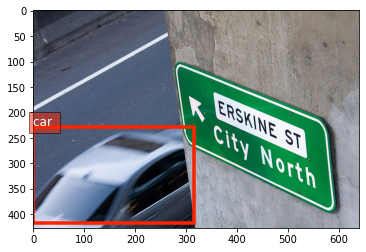

In [46]:
train_image, train_label = train_ds[97552]
bounding_boxes = train_label[:, :4]
class_ids = train_label[:, 4:5]
print(train_label.shape)

plot_image(train_image, train_label)

In [48]:
def convert_to_yolo(label, direction='to_yolo'):
    '''
    Converts the bounding boxes into the yolo format
    and vice versa
    '''
    if direction == 'to_yolo':
        # convert the bounding boxes to yolo format
        # (x, y, w, h) -> (x, y, w, h)
        # (x, y) = (x + w/2, y + h/2)
        # (w, h) = (w, h)
        yolo_label = np.zeros(label.shape)

        yolo_label[:, 0] = label[:, 0] + label[:, 2]/2
        yolo_label[:, 1] = label[:, 1] + label[:, 3]/2
        yolo_label[:, 2] = label[:, 2]
        yolo_label[:, 3] = label[:, 3]
        yolo_label[:, 4] = label[:, 4]
        return yolo_label
    elif direction == 'to_normal':
        # convert the bounding boxes to normal format
        # (x, y, w, h) -> (x, y, w, h)
        # (x, y) = (x - w/2, y - h/2)
        # (w, h) = (w, h)
        normal_label = np.zeros(label.shape)

        normal_label[:, 0] = label[:, 0] - label[:, 2]/2
        normal_label[:, 1] = label[:, 1] - label[:, 3]/2
        normal_label[:, 2] = label[:, 2]
        normal_label[:, 3] = label[:, 3]
        normal_label[:, 4] = label[:, 4]
        return normal_label
    else:
        print('Invalid direction')
        return None

(1, 5)
Yolo label: [[159.265 437.575 316.61  418.99    2.   ]]
Normal label: [[  0.96 228.08 316.61 418.99   2.  ]]
number of objects in the image: 1
bounding boxes (# boxes, min x, min y, max x, max y): 
 [[  0.96 228.08 316.61 418.99]]
class ids (# boxes, class id): 
 [[2.]]


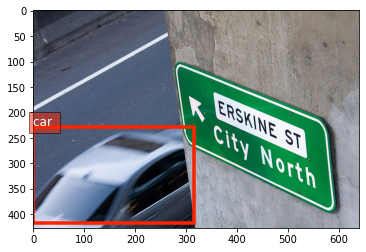

In [51]:
# convert training labels to yolo format
yolo_train_label = convert_to_yolo(train_label, direction='to_yolo')
print(yolo_train_label.shape)
print(f'Yolo label: {yolo_train_label}')
print(f'Normal label: {train_label}')
plot_image(train_image, train_label)

Building the Real Time Object Detector Model

In [ ]:
# transfer the learning
# load the pretrained model
net = cv2.dnn.readNetFromDarknet('yolov3.cfg', 'yolov3.weights')